#  Create AGB model Jan reduction
---

The original model contains more points than we need (see e.g. [De Ceuster et al. 2020](https://arxiv.org/abs/2011.14998)). Therfore we will try to reduce it.

## Imports

In [1]:
import yt
import vtk
import h5py
import meshio
import numpy           as np
import magritte.setup  as setup
import magritte.mesher as mesher
import magritte.core   as magritte

from tqdm                   import tqdm
from astropy                import constants
from vtk.util.numpy_support import vtk_to_numpy
from scipy.spatial          import Delaunay, cKDTree
from numba                  import njit
from yt.funcs               import mylog
mylog.setLevel(40) # This sets the log level to "ERROR"

/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


## Reduce mesh

In [2]:
with h5py.File('model_Jan.hdf5') as file:
    pos = np.array(file['geometry/points/position'        ], dtype = np.float64)
    nbs = np.array(file['geometry/points/neighbors'       ], dtype = np.int64  )
    nns = np.array(file['geometry/points/n_neighbors'     ], dtype = np.int64  )
    bdy = np.array(file['geometry/boundary/boundary2point'], dtype = np.int64  )
    nCO = np.array(file['chemistry/species/abundance'     ], dtype = np.float64)[:,1]

In [3]:
delaunay = Delaunay(pos)

In [4]:
@njit
def get_pfs (nns):
    pfs = np.zeros(nns.shape, dtype=np.int64)
    tot = 0
    for i, n in enumerate(nns):
        tot    += n
        pfs[i]  = tot
    return pfs
        
@njit
def get_nbs (nbs, pfs, i):
    if (i == 0):
        return nbs[0:pfs[0]]
    else:
        return nbs[pfs[i-1]:pfs[i]]

@njit
def norm (vec_arr):
    norms = np.zeros(vec_arr.shape[0])
    for i in range(vec_arr.shape[0]):
        for j in range(vec_arr.shape[1]):
            norms[i] = norms[i] + vec_arr[i,j]**2
    return np.sqrt(norms)

@njit
def get_Gs (tracer, nbs, pfs):
    Gs = np.zeros(tracer.shape[0])
    for i in range(tracer.shape[0]):
        tracer_i = tracer[i]
        tracer_n = tracer[get_nbs(nbs, pfs, i)]
        Gs[i] = np.max(np.abs(tracer_i - tracer_n) / (tracer_i + tracer_n))
    return Gs
        
@njit
def get_Ls (pos, nbs, pfs):
    Ls = np.zeros(pos.shape[0])
    for i in range(pos.shape[0]):
        Ls[i] = np.mean(norm(pos[i] - pos[get_nbs(nbs, pfs, i)]))
    return Ls

@njit
def get_weight (pos, nbs, nns, tracer, threshold=0.21, fmin=1.0, ftarget=2.15):

    pfs = get_pfs (nns)
    GGs = get_Gs  (tracer, nbs, pfs)
    LLs = get_Ls  (pos,    nbs, pfs)
    
    L_min    = fmin    * LLs
    L_target = ftarget * LLs
    
    weight = L_target
    weight[GGs > threshold] = L_min[GGs > threshold]

    return weight


# Define an outer boundary for the model
bound = 0.99 * np.min(np.linalg.norm(pos[bdy], axis=1))

In [5]:
meshName  = 'model_Jan_reduced'
scale_max = 1.0e+99
scale_min = 0.0
threshold = 0.21
fmin      = 1.0       # don't allow refinenment 
ftarget   = 2.15      # approx 10^(-1/3) for approx 10 times fewer points 

# Create a background mesh (in .mesh format)
meshio.write_points_cells(
    filename   = f'{meshName}.msh',
    points     =             delaunay.points,
    cells      = {'tetra'  : delaunay.simplices},
    point_data = {'weights': get_weight(pos=pos, nbs=nbs, nns=nns, tracer=nCO, threshold=threshold, fmin=fmin, ftarget=ftarget)}
)

# Convert .msh to .pos mesh for Gmsh
mesher.convert_msh_to_pos (meshName=meshName, replace=True)

# Create a new mesh from the background mesh
mesher.create_mesh_from_background(
    meshName  = meshName,
    boundary  = mesher.boundary_sphere(radius=bound),
    scale_min = scale_min,
    scale_max = scale_max
)

Info    : Running 'gmsh -0 model_Jan_reduced_convert_to_pos.geo' [Gmsh 4.4.1, 1 node, max. 1 thread]
Info    : Started on Thu Apr 15 19:43:13 2021
Info    : Reading 'model_Jan_reduced_convert_to_pos.geo'...
Info    : Reading 'model_Jan_reduced.msh'...
Info    : 297984 nodes
Info    : Creating discrete volume 0
Info    : 2099251 elements                                       
Info    : Done reading 'model_Jan_reduced.msh'                      
Info    : Writing 'model_Jan_reduced.pos'...
Info    : Done writing 'model_Jan_reduced.pos'
Info    : Done reading 'model_Jan_reduced_convert_to_pos.geo'
Info    : Writing 'model_Jan_reduced_convert_to_pos.geo_unrolled'...
Info    : Done writing 'model_Jan_reduced_convert_to_pos.geo_unrolled'
Info    : Stopped on Thu Apr 15 19:43:50 2021
Info    : Running 'gmsh model_Jan_reduced.geo -3 -saveall -o model_Jan_reduced.vtk' [Gmsh 4.4.1, 1 node, max. 1 thread]
Info    : Started on Thu Apr 15 19:43:50 2021
Info    : Reading 'model_Jan_reduced.geo'...
In

## Create a reduced Magritte model

In [6]:
vtk_file   = 'model_Jan_reduced.vtk'
model_file = 'model_Jan_reduced.hdf5'
lamda_file = '../../data/co.txt'

In [7]:
# Load the mesh created above
mesh = mesher.Mesh(vtk_file)

# Set model parameters
dimension = 3
npoints   = mesh.points.shape[0]
nrays     = 12
nspecs    = 5
nlspecs   = 1
nquads    = 5

# "Interpolate" (effectively just map the points)
corresp_points = cKDTree(pos).query(mesh.points)[1]

# Load original model
model = magritte.Model('model_Jan.hdf5')

# Map data
position = np.array(model.geometry.points.position        )[corresp_points]
velocity = np.array(model.geometry.points.velocity        )[corresp_points]
nCO      = np.array(model.chemistry.species.abundance     )[corresp_points,1]
nH2      = np.array(model.chemistry.species.abundance     )[corresp_points,2]
tmp      = np.array(model.thermodynamics.temperature.gas  )[corresp_points]
trb      = np.array(model.thermodynamics.turbulence.vturb2)[corresp_points]

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(position)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Convenience arrays
zeros = np.zeros(npoints)
ones  = np.ones (npoints)

0


/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [8]:
model = magritte.Model ()
model.parameters.set_spherical_symmetry(False)
model.parameters.set_pop_prec          (1.0e-6)
model.parameters.set_model_name        (model_file)
model.parameters.set_dimension         (dimension)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (nrays)
model.parameters.set_nspecs            (nspecs)
model.parameters.set_nlspecs           (nlspecs)
model.parameters.set_nquads            (nquads)

model.geometry.points.position.set(position)
model.geometry.points.velocity.set(velocity)

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((zeros, nCO, nH2, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp)
model.thermodynamics.turbulence.vturb2.set(trb)

model.parameters.set_nboundary(len(mesh.boundary))
model.geometry.boundary.boundary2point.set(mesh.boundary)

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file)
model = setup.set_quadrature              (model)

model.write()

/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]



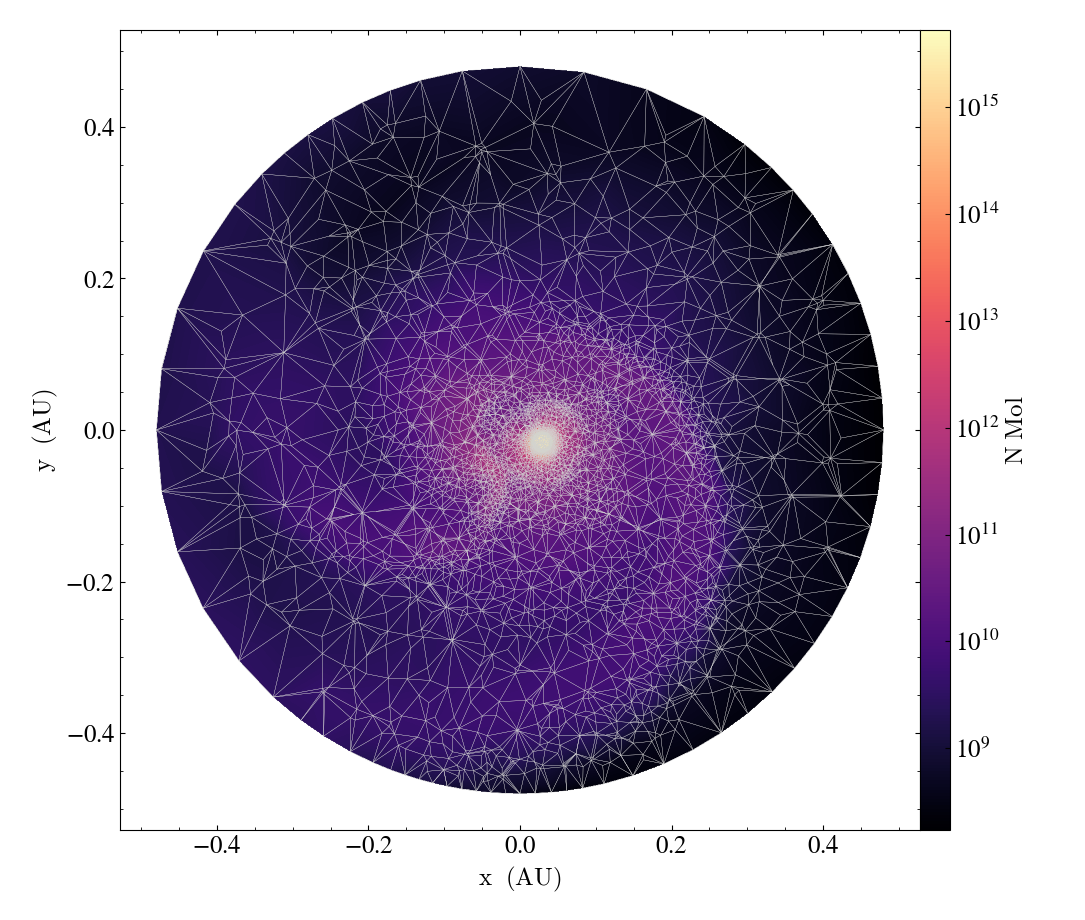

In [9]:
quantity = 'n_mol'

ds = yt.load_unstructured_mesh(
         connectivity = mesh.tetras.astype(np.int64),
         coordinates  = mesh.points.astype(np.float64),
         node_data    = {('connect1', quantity): nCO[mesh.tetras].astype(np.float64)}
)

sl = yt.SlicePlot(ds, 'z', quantity)
sl.set_log             (quantity, True)
sl.set_cmap            (quantity, 'magma')
sl.zoom                (1)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.2]})

As we can see, this model contains far fewer points.

In [10]:
model.parameters.npoints()

30378